In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf

In [2]:
#Pre-processing the input data using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
IMG_SIZE = 180
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="mri-image-dataset/Alzheimer_s Dataset/train"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [3]:
#Splitting the dataset into images and corresponding labels
train_data, train_labels = train_data_gen.next()

In [4]:
#Performing image augmentation to balance out the minority classes in the dataset
from imblearn.over_sampling import SMOTE
sm_obj = SMOTE(random_state=56)

train_data, train_labels = sm_obj.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 180, 180, 3) (10240, 4)


In [5]:
#Spltting the dataset into training, testing and validation
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=56)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=56)

In [38]:
#Importing the pre-trained ResNet50V2 from keras
from tensorflow.keras.applications import ResNet50V2
resnet_model = ResNet50V2(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

In [39]:
#Freezing the weights of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable=False

In [40]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
new_resnet_model = Sequential([
        resnet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [41]:
new_resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [43]:
hist = new_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=15)

Epoch 1/15
205/205 [==============================] - 481s 2s/step - loss: 1.2336 - accuracy: 0.7169 - val_loss: 1.1167 - val_accuracy: 0.7639
Epoch 2/15
205/205 [==============================] - 505s 2s/step - loss: 1.2547 - accuracy: 0.7191 - val_loss: 1.1208 - val_accuracy: 0.7639
Epoch 3/15
205/205 [==============================] - 528s 3s/step - loss: 1.2231 - accuracy: 0.7188 - val_loss: 1.0947 - val_accuracy: 0.7761
Epoch 4/15
205/205 [==============================] - 450s 2s/step - loss: 1.2119 - accuracy: 0.7175 - val_loss: 1.0877 - val_accuracy: 0.7913
Epoch 5/15
205/205 [==============================] - 454s 2s/step - loss: 1.2287 - accuracy: 0.7241 - val_loss: 1.1046 - val_accuracy: 0.7767
Epoch 6/15
205/205 [==============================] - 469s 2s/step - loss: 1.2666 - accuracy: 0.7278 - val_loss: 1.1756 - val_accuracy: 0.7584
Epoch 7/15
205/205 [==============================] - 442s 2s/step - loss: 1.2648 - accuracy: 0.7258 - val_loss: 1.1747 - val_accuracy: 0.7462

In [44]:
loss, accuracy = new_resnet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 102s 2s/step - loss: 1.0573 - accuracy: 0.7979


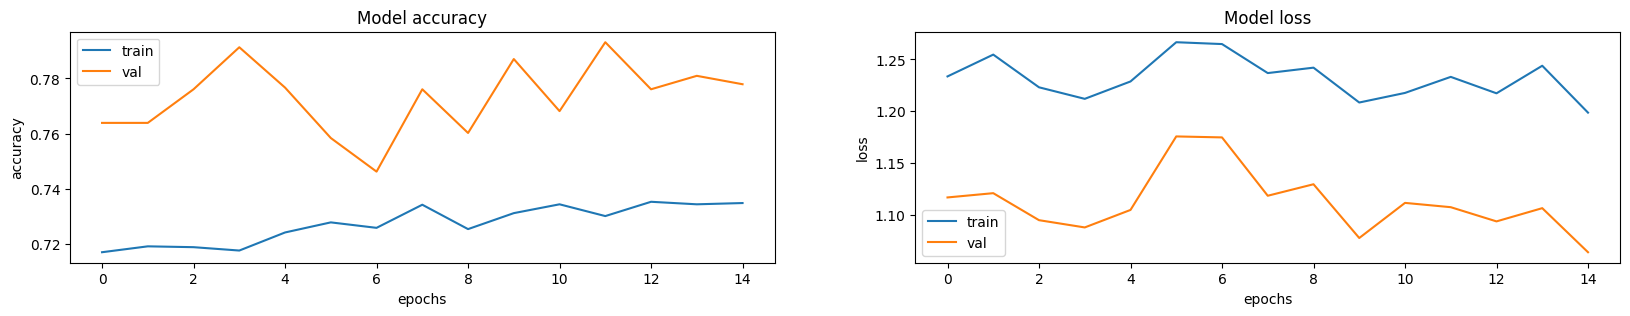

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
new_resnet_model.save('model_resnet_final_1.h5')
#Model with two l2 regulariser 0.01 and 0.001

In [47]:
for layer in resnet_model.layers[162:]:
    layer.trainable = True

In [48]:
new_resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                            loss=tf.losses.CategoricalCrossentropy(),
                            metrics=["accuracy"])

In [49]:
hist_2 = new_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)

Epoch 1/10
205/205 [==============================] - 524s 3s/step - loss: 1.2287 - accuracy: 0.6823 - val_loss: 0.9454 - val_accuracy: 0.7193
Epoch 2/10
205/205 [==============================] - 442s 2s/step - loss: 0.8076 - accuracy: 0.7830 - val_loss: 0.7927 - val_accuracy: 0.7743
Epoch 3/10
205/205 [==============================] - 452s 2s/step - loss: 0.6593 - accuracy: 0.8276 - val_loss: 0.7808 - val_accuracy: 0.7749
Epoch 4/10
205/205 [==============================] - 482s 2s/step - loss: 0.5660 - accuracy: 0.8622 - val_loss: 0.6583 - val_accuracy: 0.8096
Epoch 5/10
205/205 [==============================] - 482s 2s/step - loss: 0.5041 - accuracy: 0.8819 - val_loss: 0.6228 - val_accuracy: 0.8517
Epoch 6/10
205/205 [==============================] - 473s 2s/step - loss: 0.4771 - accuracy: 0.8978 - val_loss: 0.7158 - val_accuracy: 0.8041
Epoch 7/10
205/205 [==============================] - 486s 2s/step - loss: 0.4141 - accuracy: 0.9145 - val_loss: 0.4407 - val_accuracy: 0.8993

In [50]:
loss, accuracy = new_resnet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 138s 2s/step - loss: 0.4532 - accuracy: 0.8965


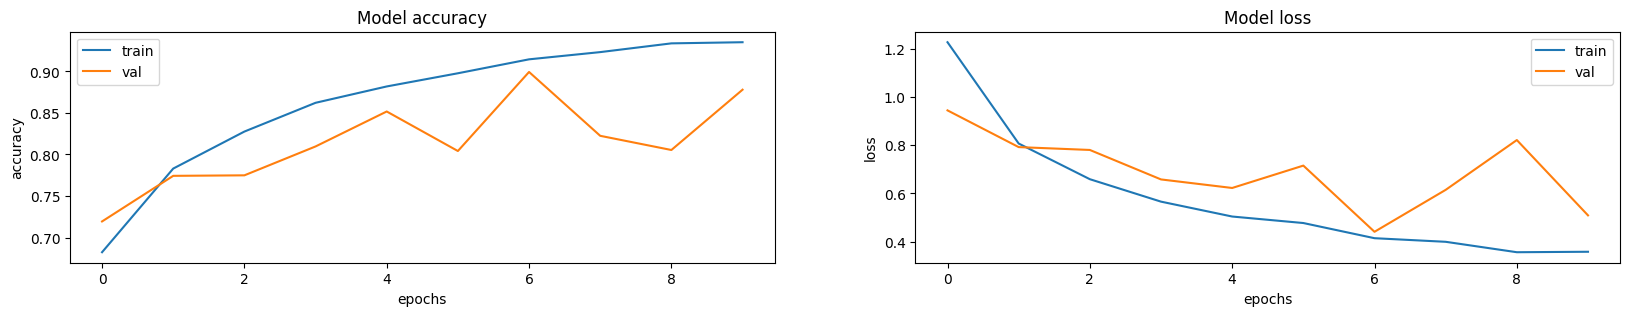

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
new_resnet_model.save('model_resnet_final_2.h5')
#After unfreezing last 28 layers of the base model and training for 10 epochs

In [58]:
hist_2 = new_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=2)

Epoch 1/2
205/205 [==============================] - 692s 3s/step - loss: 0.3554 - accuracy: 0.9435 - val_loss: 0.6028 - val_accuracy: 0.8646
Epoch 2/2
205/205 [==============================] - 692s 3s/step - loss: 0.2970 - accuracy: 0.9553 - val_loss: 0.3663 - val_accuracy: 0.9250


In [59]:
 loss, accuracy = new_resnet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 111s 2s/step - loss: 0.3551 - accuracy: 0.9248


In [60]:
new_resnet_model.save('model_resnet_final_4.h5')


In [61]:
predictions = new_resnet_model.predict(test_data)

64/64 [==============================] - 108s 2s/step


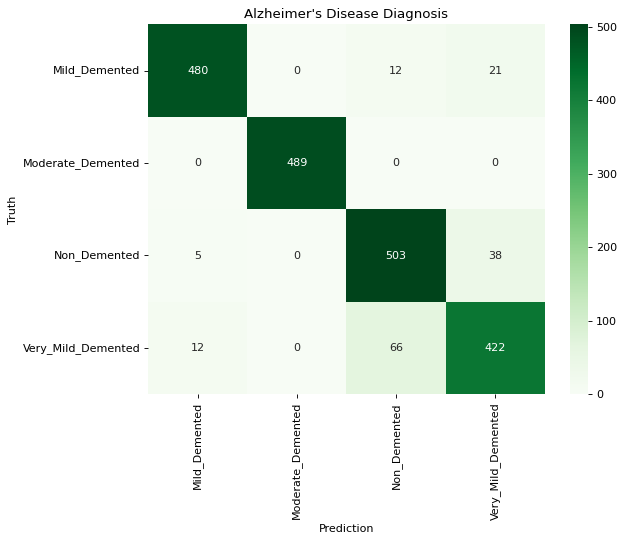

In [66]:
#Confusion matrix for final model 4
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

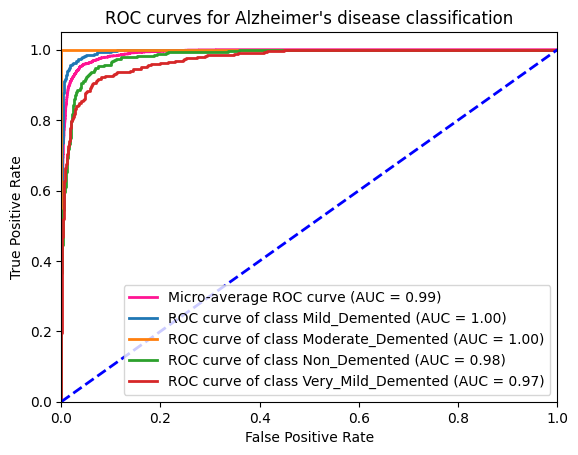

In [64]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

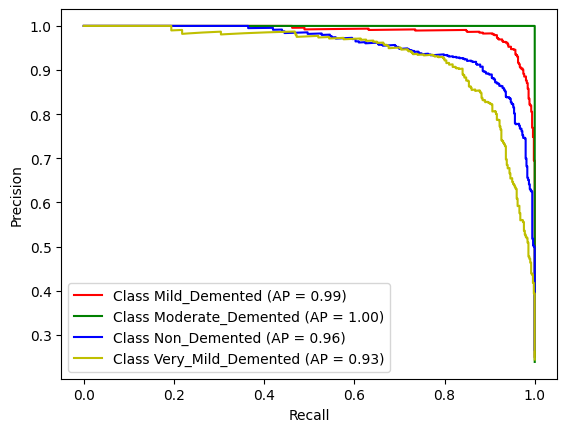

In [65]:
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()

1/1 [==============================] - 0s 138ms/step


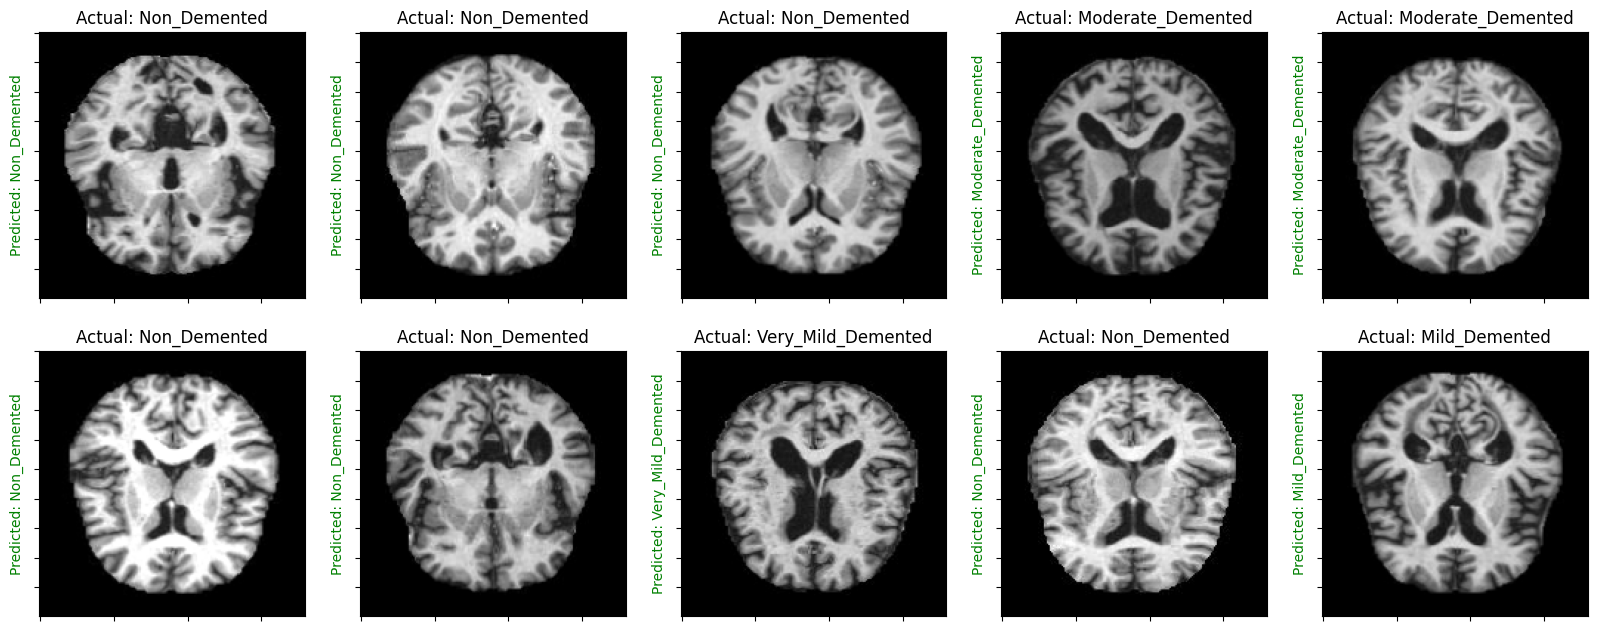

In [72]:
n = len(test_data)
indices = np.random.choice(n, 10, replace=False)
sample_data = test_data[indices]
sample_labels = test_labels[indices]
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
plt.figure(figsize=(20, 20))
for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_data[i])
        predictions = new_resnet_model.predict(sample_data[i:i+1])
        score = tf.nn.softmax(predictions[0])
        if(class_names[np.argmax(sample_labels[i])]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[np.argmax(sample_labels[i])])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[np.argmax(sample_labels[i])])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])